## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
import os

In [2]:
features = []
remote_folder = 'Gel_studies' #Folder in AWS S3 containing files to be analyzed
bucket = 'dtoghani.data'
vids = 10
mws = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Deff2',
          'Mean Mean_Intensity', 'Std Mean_Intensity',
          'X', 'Y', 'Mean X', 'Mean Y', 'Std X', 'Std Y']
calcs = [2]

counter = 0
for calc in calcs:
    for mw in mws:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}mM_XY{}.csv'.format(mw, calc, '%02d' % num)
                # os.remove(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                fstats['Particle Type'] = pd.Series(fstats.shape[0]*[mw], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                #fstats['Calcium Concentration'] = pd.Series(fstats.shape[0]*[str(calcs)], index=fstats.index)
                #print(num)
                print(filename)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('skip filename: {}'.format(filename))

features_10k_PEG_2mM_XY01.csv
features_10k_PEG_2mM_XY02.csv
features_10k_PEG_2mM_XY03.csv
features_10k_PEG_2mM_XY04.csv
features_10k_PEG_2mM_XY05.csv
features_10k_PEG_2mM_XY06.csv
features_10k_PEG_2mM_XY07.csv
features_10k_PEG_2mM_XY08.csv
features_10k_PEG_2mM_XY09.csv
features_10k_PEG_2mM_XY10.csv
features_5k_PEG_2mM_XY01.csv
features_5k_PEG_2mM_XY02.csv
features_5k_PEG_2mM_XY03.csv
features_5k_PEG_2mM_XY04.csv
features_5k_PEG_2mM_XY05.csv
features_5k_PEG_2mM_XY06.csv
features_5k_PEG_2mM_XY07.csv
features_5k_PEG_2mM_XY08.csv
features_5k_PEG_2mM_XY09.csv
features_5k_PEG_2mM_XY10.csv
features_1k_PEG_2mM_XY01.csv
features_1k_PEG_2mM_XY02.csv
features_1k_PEG_2mM_XY03.csv
features_1k_PEG_2mM_XY04.csv
features_1k_PEG_2mM_XY05.csv
features_1k_PEG_2mM_XY06.csv
features_1k_PEG_2mM_XY07.csv
features_1k_PEG_2mM_XY08.csv
features_1k_PEG_2mM_XY09.csv
features_1k_PEG_2mM_XY10.csv
features_PS_COOH_2mM_XY01.csv
features_PS_COOH_2mM_XY02.csv
features_PS_COOH_2mM_XY03.csv
features_PS_COOH_2mM_XY04.csv


In [3]:
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins']

## Train-Test Split

In [4]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [5]:
# cols = fstats_tot.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [6]:
featofvar = 'Particle Type'
#ncomp = 15

# X_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# X_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# y_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))][featofvar].values
# y_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))][featofvar].values

f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

# for run in range(1):
#     clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
#                         alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
#                         early_stopping=True, validation_fraction=0.1)

#     clf.fit(X_train, y_train)
    
#     print('Training Results')
#     y_true1, y_pred1 = y_train, clf.predict(X_train)
#     print(classification_report(y_true1, y_pred1, digits=4))
    
#     print('Test Results')
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred, digits=4))

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [7]:
ncomp = 13
pca_train = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.18031301563829844
1 component: 0.3102547143360283
2 component: 0.42047336059914675
3 component: 0.49272309416047866
4 component: 0.5508959956971156
5 component: 0.5995005642548059
6 component: 0.64196146417128
7 component: 0.679558419951313
8 component: 0.7113907397546818
9 component: 0.7424374918841999
10 component: 0.7666490857727
11 component: 0.7896906616565684
12 component: 0.8091641782506556


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [11]:
kmostat = pca.kmo(pca_train.scaled)

0.859100111858


In [12]:
pca_train.final.head()

,index,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,3,4,5,6,7,8,9,10,11,12
0,0,0.0,0.252726,3.598690,3.899991,0.962948,0.097153,0.413370,2.615649,0.617686,...,6.725878,-1.218044,1.006719,-0.588299,1.251935,0.993269,-3.395677,-1.978753,0.201058,0.022544
1,2,2.0,0.612635,1.188646,1.647832,0.949555,0.113753,0.380665,2.334891,0.571714,...,-1.065513,-0.847559,-0.083870,-0.603868,1.359791,-0.224144,1.629714,-0.718267,0.520373,0.588825
2,4,4.0,1.715690,0.013510,7.016003,0.538490,0.391820,0.100340,2.069569,0.516808,...,-4.617916,1.959058,-1.805624,0.294149,-0.749565,-0.233333,-2.107119,-1.236011,-0.946470,-0.234003
3,6,6.0,0.239083,1.471276,1.767600,0.167892,0.647067,0.023226,1.220503,0.180666,...,0.735429,-0.936498,3.160770,-0.148974,-1.508247,-0.781686,1.232871,-0.063553,0.439029,-0.086427
4,7,7.0,0.061762,0.005371,3.071312,0.512752,0.406762,0.093122,1.574208,0.364760,...,6.497808,6.659212,-6.068883,-1.220905,4.694656,-1.303997,-5.470854,-2.076248,-2.202529,1.578281


In [13]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [8]:
import numpy as np
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='10k_PEG'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='5k_PEG'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='1k_PEG'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final['Particle Type']=='PS_COOH'].values[:, -ncomp:], axis=0)

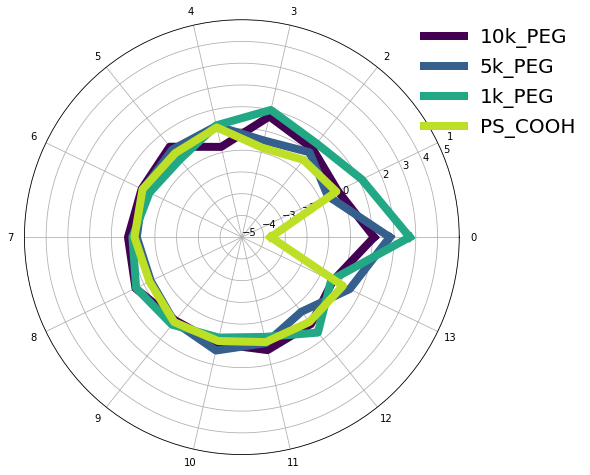

In [10]:
labels = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-5, 5, 11))

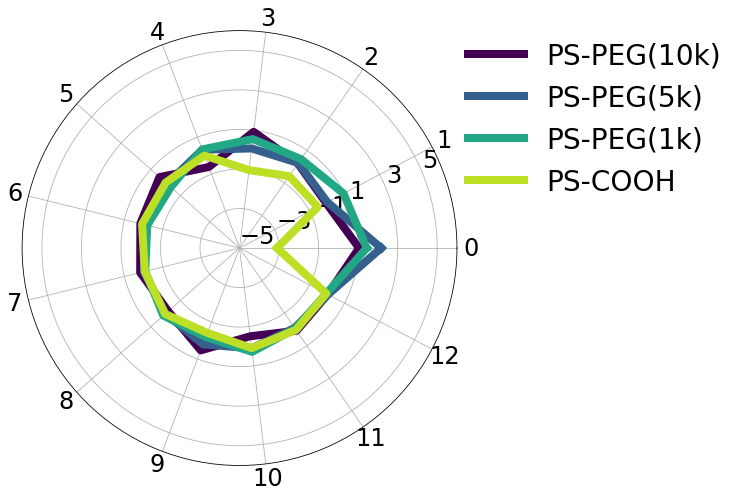

In [9]:
labels = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
labels2 = ['PS-PEG(10k)', 'PS-PEG(5k)', 'PS-PEG(1k)', 'PS-COOH']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-5, 5, 6), dpi=1200, labelsize=24,
             filename='pics/mw2_pcaavg.png')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 4)), hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

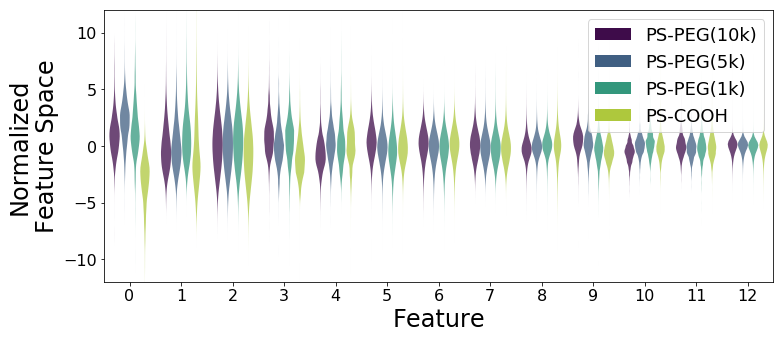

In [19]:
feats = feature_violin(pca_train.final, label='Particle Type', lvals=labels, labels=labels2, fsubset=ncomp, yrange=[-12, 12],
                       legendfontsize=21, labelsize=24, fname='./pics/mw2_pcadist.png')

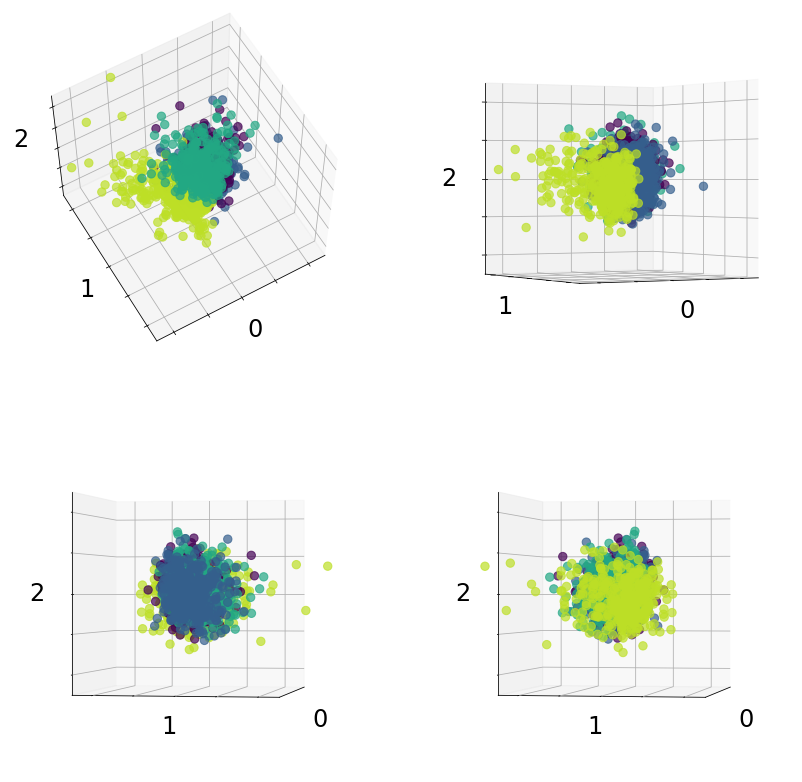

In [20]:
fstats1 = pca.feature_plot_3D(pca_train.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/mw2_3feats.png')

## Neural Network

In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [22]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.47199790
Validation score: 0.830076
Iteration 2, loss = 0.36100010
Validation score: 0.881228
Iteration 3, loss = 0.27489447
Validation score: 0.915819
Iteration 4, loss = 0.21119279
Validation score: 0.945475
Iteration 5, loss = 0.16726575
Validation score: 0.941164
Iteration 6, loss = 0.14013698
Validation score: 0.968933
Iteration 7, loss = 0.11980068
Validation score: 0.964319
Iteration 8, loss = 0.10718298
Validation score: 0.969644
Iteration 9, loss = 0.09549270
Validation score: 0.982681
Iteration 10, loss = 0.08911305
Validation score: 0.985514
Iteration 11, loss = 0.08462394
Validation score: 0.982595
Iteration 12, loss = 0.08113362
Validation score: 0.977593
Iteration 13, loss = 0.07905246
Validation score: 0.986243
Iteration 14, loss = 0.07496868
Validation score: 0.979933
Iteration 15, loss = 0.07438787
Validation score: 0.975518
Iteration 16, loss = 0.07123011
Validation score: 0.983931
Validation score did not improve more than tol=0.000010 for two c